In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt2",          # --job-name
    cores=2,                     # Number of cores per task (adjust if needed)
    processes=1,                 # One process per task
    memory="20GB",               # --mem
    walltime="01:00:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)

import glob 
import os

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35857 instead
  warnings.warn(


In [2]:
data_dir = '/home1/nalex2023/Datasets/interpsonde_manus/*.nc'

all_dsets = glob.glob(data_dir)

all_dsets

['/home1/nalex2023/Datasets/interpsonde_manus/2009_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2002_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2003_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2008_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2014_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2001_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2004_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2013_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2012_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2005_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2010_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2007_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2006_MANUS_INTERPSONDEv2.nc',
 '/home1/nal

In [3]:
from dask.distributed import Client
cluster.scale(jobs=4)
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:35857/status,
Dashboard: http://10.42.239.61:35857/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:36997,Workers: 0
Dashboard: http://10.42.239.61:35857/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [53]:
cluster.close()

In [4]:
import xarray as xr 
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

dset = xr.open_mfdataset(all_dsets, combine='by_coords').sel(time=slice('2012'))
dset['height'] = dset['height'] * 1000
dset['time'] = dset['time'].roll(time=10)

dset = dset.sortby('time')


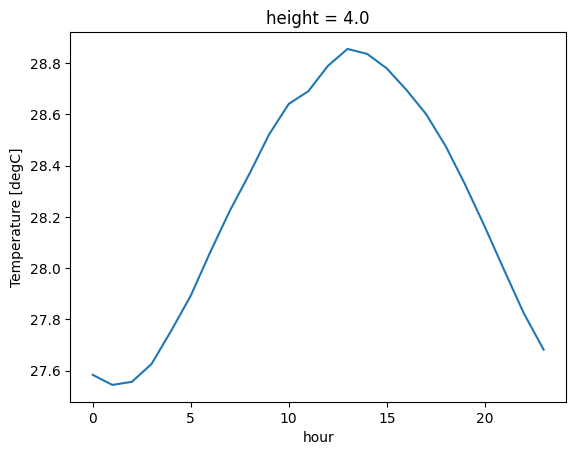

In [5]:
dset.temp.isel(height=0).groupby('time.hour').mean().plot()

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from windrose import WindroseAxes


def create_dft(in_dir,arm_data=True):
    files = glob.glob(in_dir+os.sep+'*.nc')
    if len(files) == 0:
        files = glob.glob(in_dir+os.sep+'*.cdf')
        if len(files) == 0:
            raise Exception('No files Found')
        else:
            pass
    else:
        pass
    
    dft = pd.DataFrame(files,columns=['filepath'])
    dft['filename'] = dft['filepath'].str.split(os.sep).str[-1]
    
    if arm_data:
        dft['datetime'] = pd.to_datetime(dft['filename'].str.split(
            '.',
            expand=True).iloc[:, 2] + dft['filename'].str.split(
                '.',  expand=True).iloc[:, 3],format='%Y%m%d%H%M%S')


    return dft

In [22]:
#dset['u_wind'] = dset['u_wind'] - dset['u_wind'].mean(dim='time')
#dset['v_wind'] = dset['v_wind'] - dset['v_wind'].mean(dim='time')
dset

<xarray.Dataset> Size: 1GB
Dimensions:   (time: 100800, height: 332)
Coordinates:
  * height    (height) float32 1kB 4.0 24.0 44.0 ... 3.95e+04 4e+04 4.05e+04
  * time      (time) datetime64[ns] 806kB 2001-04-05 ... 2012-12-31T23:00:00
Data variables:
    bar_pres  (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    temp      (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    dp        (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    rh        (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    u_wind    (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    v_wind    (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    angle     (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    speed     (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s twp -f C1 -b 2...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     twpgriddedsondeC1.c0 : 2.2 : 20010403.000030-20010...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               twp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Tropical Western Pacific (TWP), Manus Island, Papu...
    datastream:            twpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               created by user ttoto on machine chalk at 2016-05-...

In [16]:
dset['angle'] = (90 - np.degrees(np.arctan2(-dset['u_wind'], -dset['v_wind']))) % 360



dset['speed'] = np.sqrt((dset['u_wind'] * dset['u_wind']) + 
                        (dset['v_wind'] * dset['v_wind']))

# remove the wind direction and speed if both u and v are 0
dset['angle'] = dset['angle'].where((dset['u_wind'] == 0) & (dset['v_wind'] == 0), dset['angle'])

dset['speed'] = dset['speed'].where((dset['u_wind'] == 0) & (dset['v_wind'] == 0), dset['speed'])



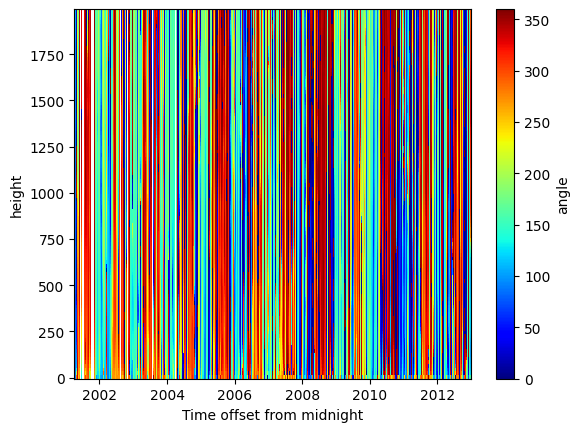

In [17]:
dset['angle'].sel(height=slice(0,2000)).plot(x='time',
                                          cmap='jet')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to create a wind rose diagram
import numpy as np
import matplotlib.pyplot as plt



DIRECTION_NAMES = ("N","NNE","NE","ENE"
                   ,"E","ESE","SE","SSE"
                   ,"S","SSW","SW","WSW"
                   ,"W","WNW","NW","NNW")

DIRECTION_ANGLES = np.arange(0, 2*np.pi, 2*np.pi/16)

# Mapping from direction name to angles in radians
NAME2ANGLE = dict(zip(
    DIRECTION_NAMES,
    DIRECTION_ANGLES
))



def windrose_histogram(wspd, wdir, speed_bins=12, normed=False, norm_axis=None):
    """
    Compute a windrose histogram given wind speed and direction data.
    
    wspd: array of wind speeds
    wdir: array of wind directions
    speed_bins: Integer or Sequence, defines the bin edges for the wind speed (default is 12 equally spaced bins)
    normed: Boolean, optional, whether to normalize the histogram values. (default is False)
    norm_axis: Integer, optional, the axis along which the histograms are normalized (default is None) 
    """

    # If speed_bins is an integer, we create linearly spaced bins from 0 to max speed
    if isinstance(speed_bins, int):
        speed_bins = np.linspace(0, wspd.max(), speed_bins)

    num_spd = len(speed_bins)
    num_angle = 16

    # Shift wind directions by 11.25 degrees (one sector) to ensure proper alignment
    wdir_shifted = (wdir + 11.25) % 360

    angle_bins = np.linspace(0, 360, num_angle + 1)

    # Generate a 2D histogram using the defined speeds bins and shifted wind directions
    hist, *_ = np.histogram2d(wspd, wdir_shifted, bins=(speed_bins, angle_bins))

    # Normalize if required
    if normed:
        hist /= hist.sum(axis=norm_axis, keepdims=True)
        hist *= 100

    return hist, angle_bins, speed_bins



def make_wind_df(data_df, num_partitions, max_speed=None, normed=False, norm_axis=None, month=None):
    """
    This function transforms raw wind speed and direction data into a DataFrame for windrose plotting.
    
    data_df: Dataframe containing wind data
    num_partitions: Integer, number of partitions to divide the wind speed data
    max_speed: Float, optional, maximum wind speed to be included in the partitions
    normed: Boolean, optional, whether to normalize the frequency values
    norm_axis: Integer, optional, the axis along which the histograms are normalized  
    """
    
    if month is not None:
        data_df = data_df[data_df.MM==month]
        
    wspd = data_df['SPD'].values
    wdir = data_df['DIR'].values

    # If max_speed is not specified, we use the maximum value in the 'wspd' data. 
    # Otherwise, we include all speeds up to and including max_speed.
    # Additional partitions are created to handle outliers.
    if max_speed is None:
        speed_bins = np.linspace(0, wspd.max(), num_partitions + 1)
    else:
        speed_bins = np.append(np.linspace(0, max_speed, num_partitions + 1), np.inf)
    
    # windrose_histogram function is called to partition data based on the bins created.
    # Additional parameters control how the frequency values are normalised

    h, *_ = windrose_histogram(wspd, wdir, speed_bins, normed=normed, norm_axis=norm_axis)

    # A dataframe is formed containing the histogram data. Column names are for the directions 
    wind_df = pd.DataFrame(data=h, columns=DIRECTION_NAMES)

    # speed_bin_names stores speed range strings to describe each interval
    # e.g. when speed_bins is [0, 3, 6], speed_bin_names is ['0-3', '3-6', '>6']
    speed_bin_names = []
    speed_bins_rounded = [round(i, 2) for i in speed_bins]
    for start, end in zip(speed_bins_rounded[:-1], speed_bins_rounded[1:]):
        speed_bin_names.append(f'{start:g}-{end:g}' if end < np.inf else f'>{start:g}')

    wind_df['strength'] = speed_bin_names

    # Reshapes data for plotting. Now, each row represents one sector of the windrose
    wind_df = wind_df.melt(id_vars=['strength'], var_name='direction', value_name='frequency')

    return wind_df


# Function to create a wind rose diagram
def matplotlib_windrose(data_df, num_partitions=4, max_speed=4, month=None):
  

    wind_df2 = make_wind_df(data_df=data_df, 
                        num_partitions=num_partitions, 
                        max_speed=max_speed, 
                        normed=True,
                        month=month)
    
    wind_df2['frequency'] = wind_df2['frequency']/ 100

    wind_df2 = wind_df2.assign(strength_start=[float(x.split('-')[0] if '-' in x else x[1:])
                                           for x in wind_df2.strength.values])
    
    wind_df2['angle'] = wind_df2.direction.map(NAME2ANGLE)
    wind_df2 = wind_df2.sort_values(by='strength_start')
    
    
    wind_df2['cumulative_frequency'] = wind_df2.sort_values(by='strength_start').groupby('direction').frequency.cumsum()

    fig, axis = plt.subplots(figsize=(8, 8), ncols=1, subplot_kw=dict(projection="polar"))
        
    axis.grid(color='white')

    strength_starts = wind_df2.strength_start.values  

    colours = plt.cm.magma_r(
        np.linspace(0, 1,  wind_df2.strength.nunique())
        )

    strength_splits = wind_df2.groupby('strength')

    for clr, strength in list(zip(colours, wind_df2.strength.unique()))[::-1]:
        split = strength_splits.get_group(strength)
        axis.bar(split['angle'].values, 
                     split['cumulative_frequency'].values, 
                     color=clr, 
                     label=strength, 
                     width=np.deg2rad(19), 
                     edgecolor='black',
                     linewidth=0.5,
                     zorder=2)

        axis.set_xticks(DIRECTION_ANGLES)
        axis.set_xticklabels(DIRECTION_NAMES)
        

        handles, labels = axis.get_legend_handles_labels()
        axis.legend(
           handles[::-1], 
           labels[::-1],
           loc='upper left', 
           bbox_to_anchor=(1.1, 1.1)
        )

        axis.set_theta_zero_location('N')

        axis.set_theta_direction(-1)


        
        axis.set_rlabel_position(135)
        yticks = axis.get_yticks()
        ytick_labels = [('{:.2f}'.format(round(i * 100, 2))[:-1]).rstrip('0').rstrip('.') + '%' for i in yticks]
        axis.set_yticks( yticks)
        axis.set_yticklabels(ytick_labels)
        
    return fig

df_winds = dset[['angle','speed']].to_dataframe().reset_index()
df_winds = df_winds.rename(columns={'angle':'DIR','speed':'SPD'})

matplotlib_windrose(df_winds, num_partitions=10, max_speed=10)


In [34]:

dset_sub = dset.mean(dim='height').sel(time=slice('2012-01-01','2012-12-31')).resample(time='1D').mean()



In [15]:
dset_sub

<xarray.Dataset> Size: 15kB
Dimensions:   (time: 366)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2012-01-01 2012-01-02 ... 2012-12-31
Data variables:
    bar_pres  (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    temp      (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    dp        (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    rh        (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    u_wind    (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    v_wind    (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    angle     (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    speed     (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>

In [26]:

import matplotlib.ticker as mtick
import matplotlib.cm as cm



def draw_windrose(data,color=cm.Blues):
    ws = data['speed'].values
    wd = data['angle'].values
    ax = WindroseAxes.from_ax()
    ax.bar(wd,ws,normed=True, bins=8, cmap=color)
    ax.set_legend()


    


def wind_rose_compare(data1,data2 ,cost_angle):
    ws1 = data1['speed'].values
    wd1 = data1['angle'].values
    ws2 = data2['speed'].values
    wd2 = data2['angle'].values
    
    ax = WindroseAxes.from_ax()
    
    ax.bar(wd1,ws1,normed=False,cmap=cm.Reds)
    ax.set_legend(loc='lower right')
    ax.bar(wd2,ws2,normed=False,cmap=cm.Blues)
    ax.set_legend(loc='lower left')
    

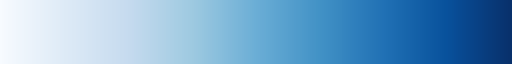

In [24]:
cm.Blues

In [27]:
a  = dset.sel(height=10,method='nearest').compute()#.sel(hour=slice(12,19))

b = dset.sel(height=slice(500,2000)).compute()#.sel(hour=slice(12,19))

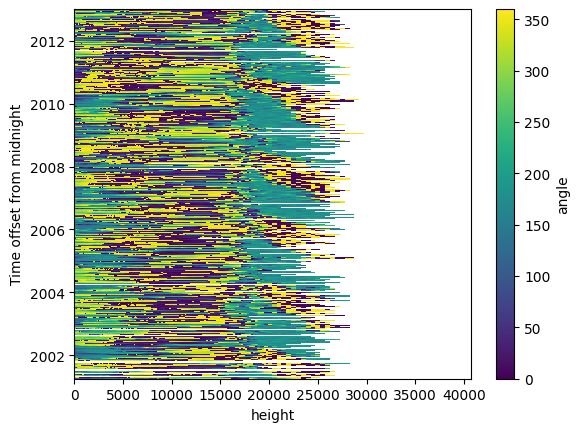

In [11]:
dset['angle'].plot()

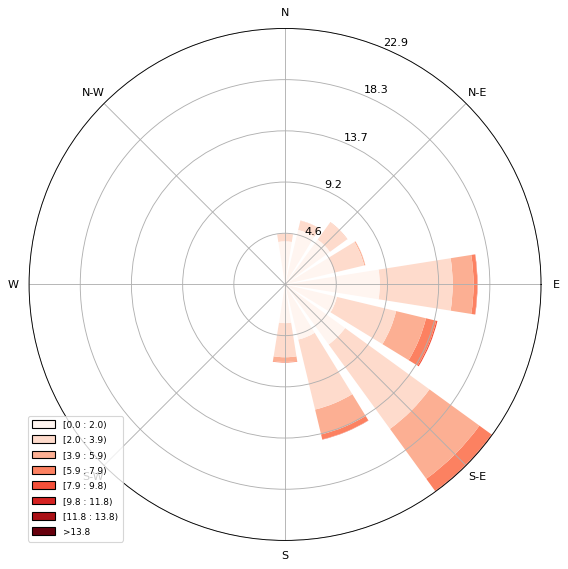

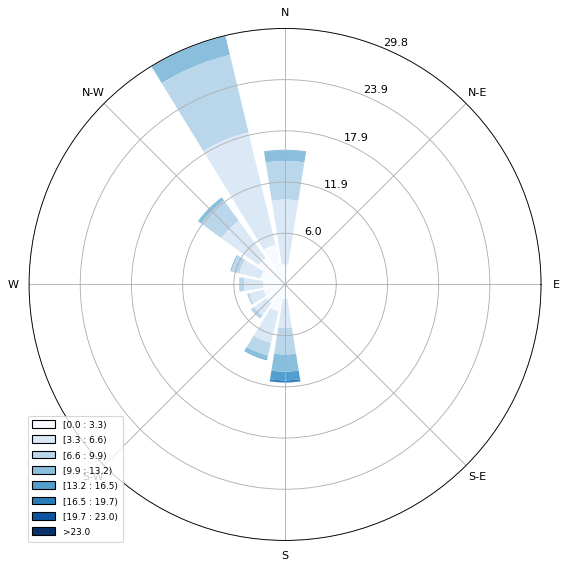

In [29]:
coast_angle = 90


def ang_diff(angle1 , coast_angle):
    diff = np.abs(angle1 - coast_angle)
    diff = np.where(diff > 180, 360 - diff, diff)
    return diff



diff_a_coast = xr.apply_ufunc(
    ang_diff,
    a['angle'],
    input_core_dims=[[]],
    vectorize=True,
    kwargs={'coast_angle': coast_angle},  # Pass the coast angle as a keyword argument
    dask='parallelized',
    output_dtypes=[np.float64],
)


diff_b_coast = xr.apply_ufunc(
    ang_diff,
    b['angle'],  # b['angle'] is a 2D array with shape (time, height)
    input_core_dims=[['time', 'height']],  # The first input is 2D, the second is scalar
    vectorize=True,  # Apply the function element-wise
    output_core_dims=[['time', 'height']],  # The output should have the same 2D shape
    dask='parallelized',  # Enable parallelization with Dask
    kwargs={'coast_angle': coast_angle + 180}, 
    output_dtypes=[np.float64],  # Specify output data type
)





a_within_90 = a.where(diff_a_coast <= 90, drop=True)

b_within_180 = b.where(diff_b_coast <= 90, drop=True)

draw_windrose(a_within_90,color=cm.Reds)

draw_windrose(b_within_180.mean(dim='height'),color=cm.Blues)
# at this point , we havent compared the two level winds, we just have the winds that are towards the land (sea breeze) and the winds that are away from the land (land breeze) 


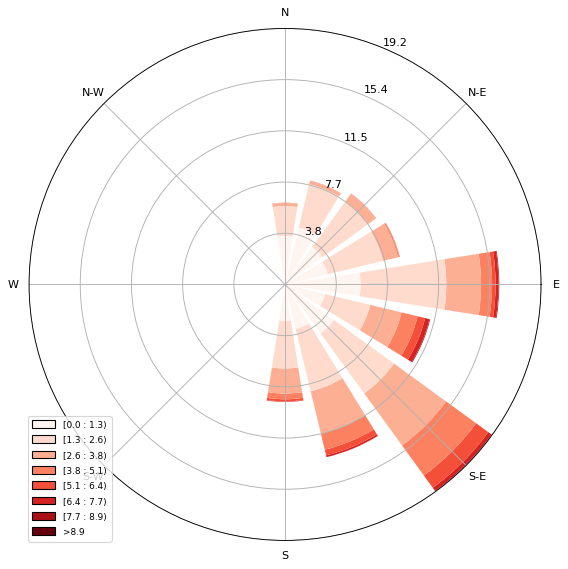

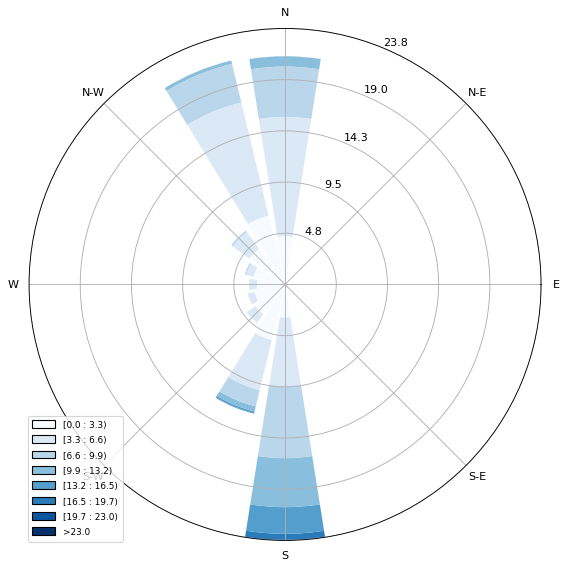

In [31]:
a_within_90, b_within_180 = xr.align(a_within_90, b_within_180, join='inner')


draw_windrose(a_within_90,color=cm.Reds)
draw_windrose(b_within_180.mean(dim='height'),color=cm.Blues)

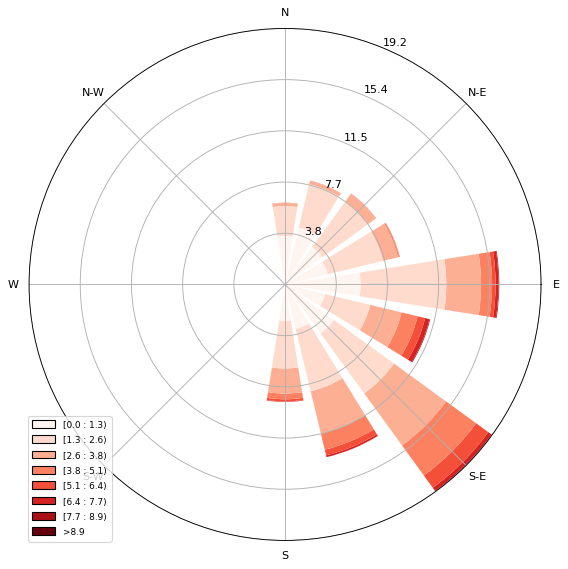

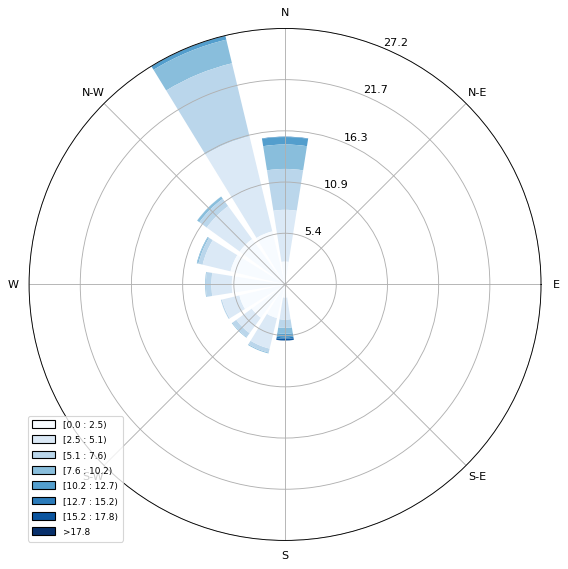

In [32]:


def oppo_upper(a,b):
    a_expanded = a[:, np.newaxis]  # This reshapes 'a' from (27192,) to (27192, 1)
    diff_from_a = ang_diff(b, a_expanded + 180)
    return diff_from_a

diff_from_a = xr.apply_ufunc(
    oppo_upper,
    a_within_90['angle'],
    b_within_180['angle'],
    input_core_dims=[['time'], ['time', 'height']],
    output_core_dims=[['time', 'height']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float64],
)

diff_from_a = b_within_180.where((diff_from_a < 90), drop=True)


draw_windrose(a_within_90,color=cm.Reds)
draw_windrose(diff_from_a.mean(dim='height'),color=cm.Blues)



In [33]:
a_aligned , b_aligned = xr.align(a_within_90,diff_from_a,join='inner')


In [34]:

def oppo_upper(a,b):
    a_expanded = a[:, np.newaxis]  # This reshapes 'a' from (27192,) to (27192, 1)
    diff_from_a = ang_diff(b, a_expanded + 180)
    return diff_from_a




def calc_SBI(a, b, cost_angle):
    # Explicitly add a new axis to 'a' to allow broadcasting over the height dimension
    # 'a' should have shape (27192, 1) to match the (27192, 75) shape of 'b'
    a_expanded = a[:, np.newaxis]  # This reshapes 'a' from (27192,) to (27192, 1)
    
    # Now 'a_expanded' can be broadcasted to (27192, 75)
    SBI = np.cos(np.radians(a_expanded - cost_angle)) * np.cos(a_expanded + 180 - b)
    return SBI

"""
SBI = xr.apply_ufunc(
    calc_SBI,
    a_within_90,
    b_within_180,
    input_core_dims=[['time'], ['time']],
    vectorize=True,
    dask='parallelized',
    
)
"""
"""
SBI = xr.apply_ufunc(
    calc_SBI,
    a_aligned,  # Aligned dataset a (with time)
    b_aligned,  # Aligned dataset b (with time and height)
    input_core_dims=[['time'], ['time', 'height']],  # time for a, time and height for b
    output_core_dims=[['time', 'height']],  # Output has time and height dimensions
    kwargs={'cost_angle': coast_angle},  # Pass cost_angle as keyword argument
    vectorize=True,  # Vectorizing the operation over the time and height dimensions
    dask='parallelized',  # Enable parallelization with Dask
)
"""
SBI = xr.apply_ufunc(
    calc_SBI,
    a_aligned,  # Aligned dataset a (with time)
    diff_from_a,  # Aligned dataset b (with time and height)
    input_core_dims=[['time'], ['time', 'height']],  # time for a, time and height for b
    output_core_dims=[['time', 'height']],  # Output has time and height dimensions
    kwargs={'cost_angle': coast_angle},  # Pass cost_angle as keyword argument
    vectorize=True,  # Vectorizing the operation over the time and height dimensions
    dask='parallelized',  # Enable parallelization with Dask
)


SBI['SBI_index'] = SBI['angle']


#SBI = np.cos(np.radians(a_within_90['angle'] - cost_angle)) * np.cos(a_within_90['angle'] + 180 - b_within_180['angle'])

#SBI_diurnal = SBI.groupby('time.hour').sum(dim='time').compute()

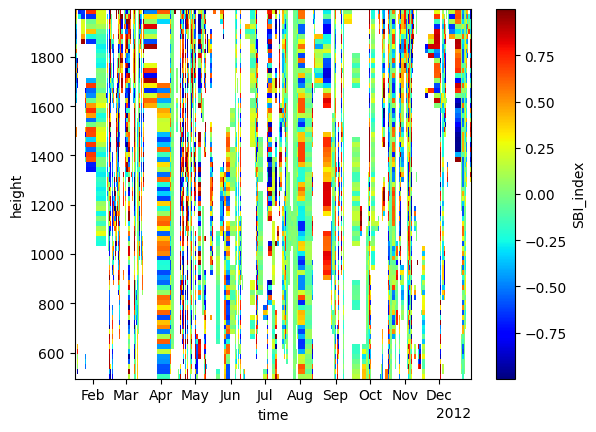

In [35]:
SBI['SBI_index'].sel(time='2012').plot(x='time', cmap='jet')

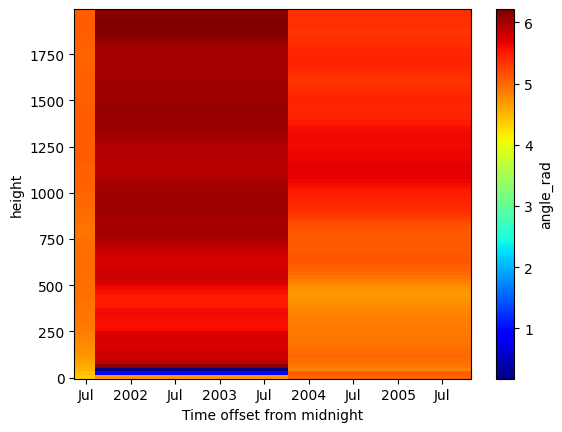

In [36]:
SBI_final = SBI['SBI_index'].max(dim='height').compute()

sea_breeze_days  = (SBI_final[SBI_final == 1]).time.dt.date


dset_sea_breeze_days = dset.sel(time=sea_breeze_days).compute()

dset_sea_breeze_days['angle_rad'] = np.radians(dset_sea_breeze_days['angle'])

dset_sea_breeze_days.sel(height=slice(0,2000)).isel(time=slice(0,10)).angle_rad.plot(x='time', cmap='jet')

,time,SBI_index
0,2001-04-05 09:00:00,0.010761
1,2001-04-05 10:00:00,0.041194
2,2001-04-05 11:00:00,0.084984
3,2001-04-05 12:00:00,0.126364
4,2001-04-05 13:00:00,0.164196
...,...,...
12554,2012-12-28 17:00:00,0.880647
12555,2012-12-28 18:00:00,0.879870
12556,2012-12-28 19:00:00,0.882942
12557,2012-12-28 20:00:00,0.847303


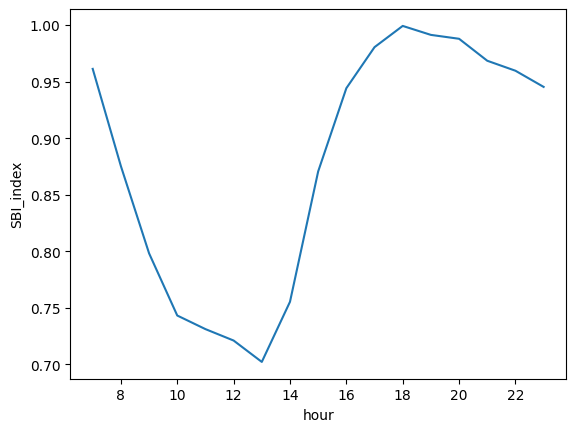

In [38]:



SBI_final.sel(time='2012-10-01').groupby('time.hour').mean().plot(x='hour')

final_csv = SBI_final.to_dataframe().reset_index()


final_csv

In [48]:
met_fol = '/home1/nalex2023/Datasets/met_manus/'

met_dft = create_dft(met_fol,arm_data=False)

#met_dft_2012 = met_dft[met_dft['datetime'].dt.month.isin([4,5,6])][met_dft['datetime'].dt.year == 2012]


met_dft['year'] = met_dft['filename'].str.split('_').str[-1].str.split('.').str[0]

met_dft['year'] = met_dft['year'].astype(int)

met_dft_2012 = met_dft[met_dft['year'] == 2012]

In [52]:


#dset_met_manus = xr.open_mfdataset(met_dft_2012['filepath'].values, combine='by_coords',chunks='auto').sel(time=slice('2012-04-01','2012-06-30'))


dset_met_manus = xr.open_dataset(met_dft_2012['filepath'].values[0])

dset_met_manus

<xarray.Dataset> Size: 19MB
Dimensions:               (time: 526738)
Coordinates:
  * time                  (time) datetime64[ns] 4MB 2012-01-01 ... 2012-12-31...
Data variables:
    atmos_pressure        (time) float32 2MB ...
    temp_mean             (time) float32 2MB ...
    rh_mean               (time) float32 2MB ...
    wspd_arith_mean       (time) float32 2MB ...
    wdir_vec_mean         (time) float32 2MB ...
    org_precip_rate_mean  (time) float32 2MB ...
    alt                   (time) float32 2MB ...
Attributes: (12/31)
    command_line:                met_ingest -s twp -f C1
    process_version:             ingest-met-4.7-0.el5
    dod_version:                 met-b1-3.2
    site_id:                     twp
    facility_id:                 C1: Momote, Manus Island
    data_level:                  b1
    ...                          ...
    qc_bit_3_description:        Value is greater than the valid_max.
    qc_bit_3_assessment:         Bad
    qc_bit_4_description:        Difference between current and previous valu...
    qc_bit_4_assessment:         Indeterminate
    zeb_platform:                twpmetC1.b1
    history:                     created by user dsmgr on machine gold at 1-J...

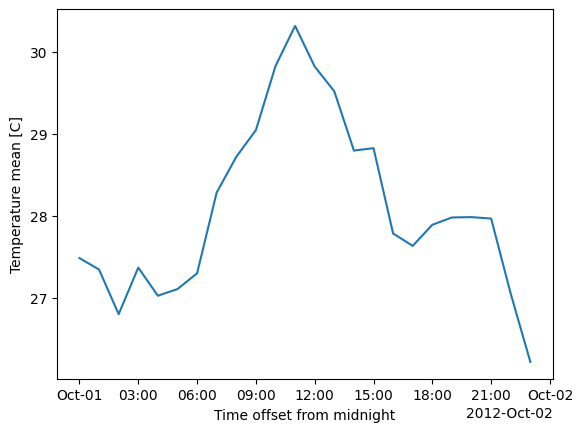

In [54]:
surface_temp = dset_met_manus['temp_mean'].resample(time='1h').mean().roll(time=10)


surface_temp.sel(time='2012-10-01').plot()

In [ ]:

era5_data_2012 = xr.open_mfdataset(
    'Datasets/era5_manus/*201210*.nc'
)

era5_data_2012_oct_2 = era5_data_2012.sel(valid_time='2012-10-01')


era5_data_2012_oct_2['speed'] = era5_data_2012_oct_2[]

<xarray.Dataset> Size: 221MB
Dimensions:         (valid_time: 24, pressure_level: 8, latitude: 41,
                     longitude: 1169)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 192B 2012-10-01 ... 2012-10-0...
  * pressure_level  (pressure_level) float64 64B 1e+03 900.0 ... 400.0 300.0
  * latitude        (latitude) float64 328B 5.0 4.75 4.5 ... -4.5 -4.75 -5.0
  * longitude       (longitude) float64 9kB -141.0 -140.8 -140.5 ... 150.8 151.0
    expver          (valid_time) <U4 384B dask.array<chunksize=(24,), meta=np.ndarray>
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 37MB dask.array<chunksize=(24, 2, 11, 390), meta=np.ndarray>
    q               (valid_time, pressure_level, latitude, longitude) float32 37MB dask.array<chunksize=(24, 2, 11, 390), meta=np.ndarray>
    t               (valid_time, pressure_level, latitude, longitude) float32 37MB dask.array<chunksize=(24, 2, 11, 390), meta=np.ndarray>
    u               (valid_time, pressure_level, latitude, longitude) float32 37MB dask.array<chunksize=(24, 2, 11, 390), meta=np.ndarray>
    v               (valid_time, pressure_level, latitude, longitude) float32 37MB dask.array<chunksize=(24, 2, 11, 390), meta=np.ndarray>
    w               (valid_time, pressure_level, latitude, longitude) float32 37MB dask.array<chunksize=(24, 2, 11, 390), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-30T02:22 GRIB to CDM+CF via cfgrib-0.9.1...

In [137]:
SBI_high = SBI_final.where(SBI_final > 0, drop=True).sel(time=slice('2012-04-01','2012-06-30'))

time_highs = SBI_high.time

#temp_surface = dset['temp'].sel(height=2,method='nearest').sel(time=time_highs).compute()
temp_surface = surface_temp.sel(time=time_highs,method='nearest').compute()



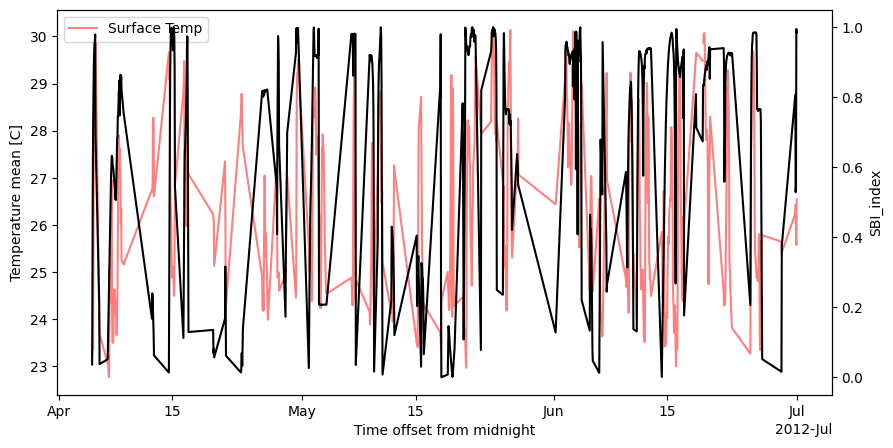

In [138]:
fig,ax = plt.subplots(1,1,figsize=(10,5))


ax2 = ax.twinx()

SBI_high.plot(ax=ax2, color='black', label='SBI > 0.8')
temp_surface.plot(ax=ax, color='red', label='Surface Temp',alpha=0.5)

ax.legend(loc='upper left')

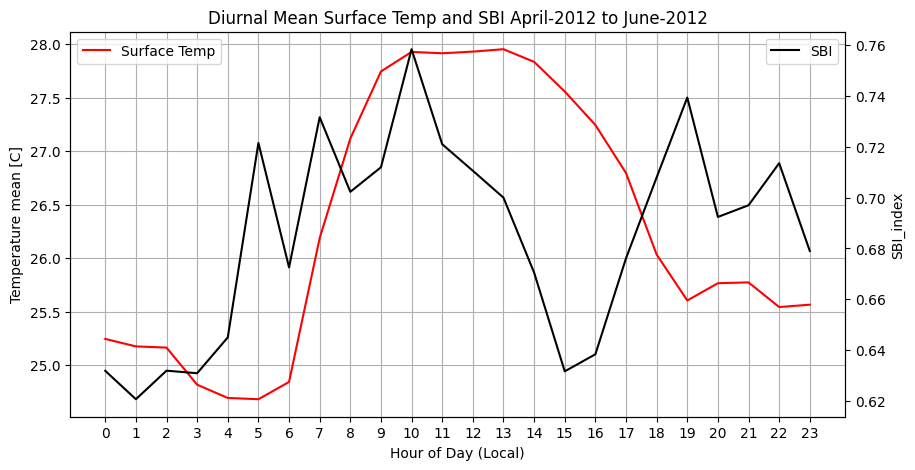

In [141]:
diurnal_surf_temp = temp_surface.groupby('time.hour').mean(dim='time').compute()

diurnal_sbi = SBI_high.groupby('time.hour').mean(dim='time').compute()


fig,ax = plt.subplots(1,1,figsize=(10,5))

ax2 = ax.twinx()

diurnal_surf_temp.plot(ax=ax, color='red', label='Surface Temp')

diurnal_sbi.plot(ax=ax2, color='black', label='SBI > 0.8')


new_dft = SBI_diurnal.to_dataframe().reset_index()

# add more tick labels on x axis 

ax.set_xticks(np.arange(0, 24, 1))
ax.set_xticklabels(np.arange(0, 24, 1), rotation=0)

ax.legend(['Surface Temp'],loc='upper left')
ax2.legend(['SBI'],loc='upper right')
ax.set_xlabel('Hour of Day (Local)')

ax.set_title('Diurnal Mean Surface Temp and SBI April-2012 to June-2012')
ax.grid()

In [37]:
new_dft_diurnal = new_dft.set_index('hour')

temp_dft = diurnal_surf_temp.to_dataframe().reset_index().set_index('hour')

new_dft_diurnal['temp'] = temp_dft['temp_mean']

final_cols = new_dft_diurnal.drop(columns=['height'])

final_cols.corr()

,angle,temp
angle,1.000000,-0.239812
temp,-0.239812,1.000000


In [ ]:
# lead lag correlation 

